<a href="https://colab.research.google.com/github/UN-things/IS-project/blob/main/IS_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nombre cool del proyecto :3

**Integrantes:**
- Valeria Huepa Ducuara
- Liseth Yurany Arevalo Yaruro
- Guiselle Tatiana Zambrano Penagos

## Comprensión del Negocio

[TripAdvisor](https://www.tripadvisor.co/) es un sitio web estadounidense que proporciona reseñas de contenido relacionado con viajes, es gratuita y se financia con publicidad. Esta empresa busca encontrar un modo de mantener o incrementar el flujo de usuarios que la visitan (huéspedes y propietarios), pues es con este volúmen con el que cuenta para recaudar dinero de la publicidad que expone en su sitio web.

Una solución propuesta es emplear las reseñas que los huéspedes dejan y ofrecer un análisis de sentimiento general, donde se puedan evidenciar cuales son los factores que más llaman la atención de los usuarios y cuales son los determinantes de una mala o buena experiencia. Así los propietarios de hoteles que usen el sitio mejorarán su servicio y los huéspedes estararán satifechos con el servicio de los hoteles y las ofertas que ofrezaca la página web, manteniendo e incrementando la cantidad de usuarios que la usen.

## Comprensión de los datos

Para la realización de esta fase, empezaremos por explorar los datos directamente con ayuda de algunas librerías disponibles en python.

### Librerías requeridas

In [1]:
%%capture
pip install --upgrade pycaret

In [2]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import nltk
from pycaret.nlp import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

In [3]:
#For Google Colab only
from pycaret.utils import enable_colab 
enable_colab()

Colab mode enabled.


In [4]:
%%capture
color = sns.color_palette()
py.init_notebook_mode(connected=True)
nltk.download('vader_lexicon')

In [5]:
%%capture
! mkdir -p data
! cd data && wget -nc https://raw.githubusercontent.com/UN-things/IS-project/main/data/tripadvisor_hotel_reviews.csv

### Lectura de datos

A continuación veremos una pequeña muestra de los datos.

Este datasetestá compuesto por 2 atributos (`Review` y `Rating`) con 20490 registros.*texto en cursiva*

In [6]:
df = pd.read_csv('data/tripadvisor_hotel_reviews.csv', sep=',')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [7]:
print("El dataset tiene la siguiente dimensionalidad:", df.shape)

El dataset tiene la siguiente dimensionalidad: (20491, 2)


Ahora veremos que tipo de atributos posee el dataset:

#### **Rating**
- Es un tipo de dato numérico que, por registro, toma uno de los los valores de `{1, 2, 3, 4, 5}`.
- Este indica la puntuación que otorgan los usuarios a un hotel presente en la plataforma.
- A partir de la grafica podemos ver que la mayoría de los usuario tienen una opinión positiva frente a los hoteles que aparecen en la plataforma

In [8]:
print("El conjunto de valores que toma el atributo 'Rating' es:", df["Rating"].unique())

El conjunto de valores que toma el atributo 'Rating' es: [4 2 3 5 1]


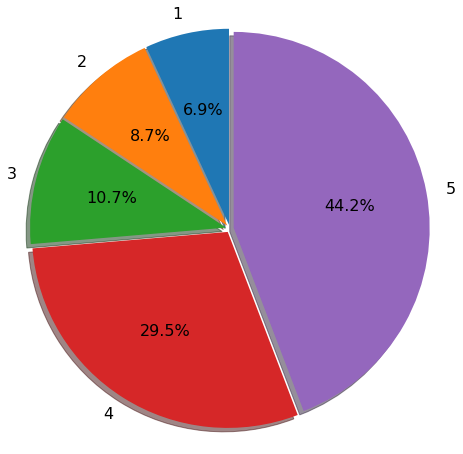

In [9]:
temp = df.groupby('Rating').size().reset_index(name="count")
temp['Percentage'] = round(100 * temp['count']  / temp['count'].sum(), 2)

plt.rcParams['font.size'] = 16.0

labels = temp['Rating']
sizes = temp['Percentage']
explode = (0.02, 0.02, 0.02, 0.02, 0.02)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#### **Review**
- Es un tipo de dato categórico.
- En este se describe la persepción de los usuarios frente a los hoteles que aparecen el la página de TripAdvisor.
- En promedio la retroalimentación brindada por los usuarios consta de 725 caracteres.

In [10]:
df["Length"] = df["Review"].apply(len)
print("El review más corto consta de", df["Length"].min(), "caracteres.")
print("El review más largo consta de", df["Length"].max(), "caracteres.")
print("En promedio los reviews tienen una longitud de ", df["Length"].mean(), "caracteres.")

El review más corto consta de 44 caracteres.
El review más largo consta de 13501 caracteres.
En promedio los reviews tienen una longitud de  724.896832755844 caracteres.


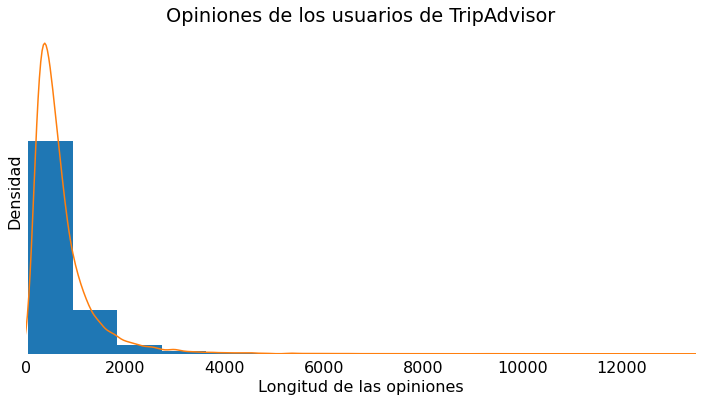

In [11]:
fig, ax = plt.subplots(figsize = (12,6))
df["Length"].plot(kind = "hist", density = True, bins = 15) # change density to true, because KDE uses density
df["Length"].plot(kind = "kde")

ax.set_ylabel("Densidad")
ax.set_yticks([])

ax.set_xlabel("Longitud de las opiniones")
ax.set_xlim(0, 13500)

ax.set_title("Opiniones de los usuarios de TripAdvisor")

ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.show()

### Conclusiones
- Ambos atributos (`Review` y `Rating`) son prometedores, esto porque permiten describir cuál es la percepación que tienen los usuarios de TripAdvisor sobre los Hoteles que se encentran en su página web.
- Hay una gran cantidad de datos, suficientes para crear un modelo que describa adecuadamente cuál es la percepción de los usuarios frente a los aspectos que rodean a un Hotel.
- Los datos vistos a simple vista muestran que en general los usuarios están conformes con los servicios ofrecidos por los hoteles.

## Preparación de los datos

En esta etapa nos enfocaremos en generar nuevas columnas en el dataset que nos indiquen de una mejor forma cuál es el sentimiento de los usuarios frente a los hoteles, así podremos definir cuáles datos son los más importantes y cuáles pueden ser descartados.

Usaremos `SentimentIntensityAnalyzer` de la librería `nltk`, luego usaremos la función `polarity_scores` que nos arrojá  un objeto cuyos valores describiran el porcentaje presente de cada sentimiento (positivo, neutral y negativo) del texto procesado.

`polarity_scores` arrojará un dato adicional llamado `compound`, este es un flotante que tiene valores entre el rango $[-1,1]$ e indica el sentimiento de un texto, donde:
- Si es mayor a cero, se concidera positivo.
- Si es igual a cero, se concidera neutral.
- Si es menor a cero, se concidera negativo.

Finalmente estos valores son almacenados en una nueva columna llamada `Scores`.

In [12]:
sid = SentimentIntensityAnalyzer()
df['Scores'] = df['Review'].apply(lambda hotel: sid.polarity_scores(str(hotel)))
df.head()

,Review,Rating,Length,Scores
0,nice hotel expensive parking got good deal sta...,4,593,"{'neg': 0.072, 'neu': 0.643, 'pos': 0.285, 'co..."
1,ok nothing special charge diamond member hilto...,2,1689,"{'neg': 0.11, 'neu': 0.701, 'pos': 0.189, 'com..."
2,nice rooms not 4* experience hotel monaco seat...,3,1427,"{'neg': 0.081, 'neu': 0.7, 'pos': 0.219, 'comp..."
3,"unique, great stay, wonderful time hotel monac...",5,600,"{'neg': 0.06, 'neu': 0.555, 'pos': 0.385, 'com..."
4,"great stay great stay, went seahawk game aweso...",5,1281,"{'neg': 0.135, 'neu': 0.643, 'pos': 0.221, 'co..."


Creamos una nueva columna llamada `Compound`, esta almacenará el item `compound` de la columna `Scores`.
Con ayuda de la función `describe` podemos ver una descripción general de los datos que tenemos hastaahora.

Podemos ver que para el atriuto `Compound` en promedio su valor es de `0.8`, esto es bueno, ya que nos indica que la percepción de gran parte de los usuarios es positiva.

In [13]:
df['Compound'] = df['Scores'].apply(lambda score_dict: score_dict['compound'])
df.describe()

,Rating,Length,Compound
count,20491.000000,20491.000000,20491.000000
mean,3.952223,724.896833,0.803430
std,1.233030,689.101024,0.455671
min,1.000000,44.000000,-0.997400
25%,3.000000,339.000000,0.918400
50%,4.000000,537.000000,0.973800
75%,5.000000,859.000000,0.988800
max,5.000000,13501.000000,0.999900


Ahora crearemos una nueva columna categórica llamada `Sentiment` esta estará compuesta por uno de 3 valores (`POSITIVE`, `NEUTRAL` Y `NEGATIVE`), nos permitirá clasificar los `Reviews` y darles un tratamiento especializado más adelante.

In [14]:
df['Sentiment']=''
df.loc[df.Compound>0,'Sentiment']='POSITIVE'
df.loc[df.Compound==0,'Sentiment']='NEUTRAL'
df.loc[df.Compound<0,'Sentiment']='NEGATIVE'
df.head()

,Review,Rating,Length,Scores,Compound,Sentiment
0,nice hotel expensive parking got good deal sta...,4,593,"{'neg': 0.072, 'neu': 0.643, 'pos': 0.285, 'co...",0.9747,POSITIVE
1,ok nothing special charge diamond member hilto...,2,1689,"{'neg': 0.11, 'neu': 0.701, 'pos': 0.189, 'com...",0.9787,POSITIVE
2,nice rooms not 4* experience hotel monaco seat...,3,1427,"{'neg': 0.081, 'neu': 0.7, 'pos': 0.219, 'comp...",0.9889,POSITIVE
3,"unique, great stay, wonderful time hotel monac...",5,600,"{'neg': 0.06, 'neu': 0.555, 'pos': 0.385, 'com...",0.9912,POSITIVE
4,"great stay great stay, went seahawk game aweso...",5,1281,"{'neg': 0.135, 'neu': 0.643, 'pos': 0.221, 'co...",0.9797,POSITIVE


Graficaremos la proporcionalidad presente en el dataset frente al atributo `Sentimet`.

Podemos observar que la mayor parte corresponde a reseñas positivas y colo el $0.1 \%$ de estas son neutrales.

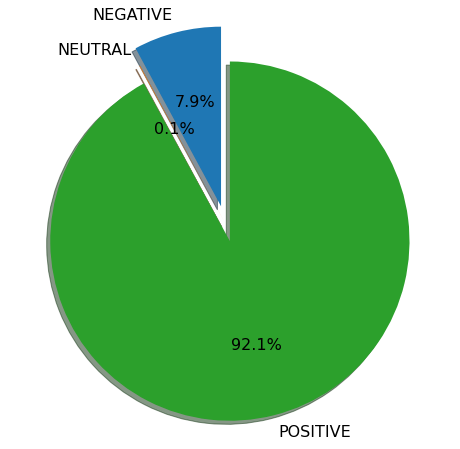

In [15]:
temp_2 = df.groupby('Sentiment').size().reset_index(name="count")
temp_2['Percentage'] = round(100 * temp_2['count']  / temp_2['count'].sum(), 2)

labels = temp_2['Sentiment']
sizes = temp_2['Percentage']
explode = (0.1, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.rcParams['font.size'] = 16.0

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Modelado

Para la realización del modelo utilizaremos `pycaret`, en específico su módulo `NLP`.

El módulo NLP (Natural Language Processing) de PyCaret (`pycaret.nlp`) es un módulo de aprendizaje automático no supervisado que se puede utilizar para analizar los datos de texto mediante la creación de un modelo de tema para encontrar la estructura semántica oculta en los documentos. El módulo NLP de PyCaret viene integrado con una amplia gama de técnicas de preprocesamiento de texto, que es el paso fundamental en cualquier problema de NLP. Transforma el texto sin procesar en un formato del que pueden aprender los algoritmos de aprendizaje automático.

### Configuración del entorno

La función `setup()` inicializa el entorno en pycaret y realiza varios pasos de preprocesamiento de texto que son imperativos para trabajar con problemas de PNL. setup debe ser llamado antes de ejecutar cualquier otra función en pycaret. Se necesitan dos parámetros: el marco de datos de pandas y el nombre de la columna de texto pasada como parámetro de destino.

Cuando se ejecuta la configuración, los siguientes pasos de preprocesamiento se aplican automáticamente:

- **Eliminación de caracteres numéricos:** todos los caracteres numéricos se eliminan del texto. Se reemplazan con espacios en blanco.
- **Eliminación de caracteres especiales:** todos los caracteres especiales no alfanuméricos se eliminan del texto. También se reemplazan con espacios en blanco.
- **Tokenización de palabras:** la tokenización de palabras es el proceso de dividir una gran muestra de texto en palabras. Este es el requisito fundamental en las tareas de procesamiento del lenguaje natural, en las que cada palabra debe capturarse por separado para su posterior análisis.
- **Eliminación de palabras vacías:** una palabra vacía (o palabra irrelevante) es una palabra que a menudo se elimina del texto porque es común y proporciona poco valor para la recuperación de información, aunque puede ser lingüísticamente significativa. Ejemplos de tales palabras en idioma inglés son: "the", "a", "an", "in", etc.
- **Extracción de bigrama:** un bigrama es una secuencia de dos elementos adyacentes de una cadena de tokens, que suelen ser letras, sílabas o palabras. Por ejemplo: la palabra New York se captura como dos palabras diferentes "New" y "York" cuando se realiza la tokenización, pero si se repite las veces suficientes, `Bigram Extraction` representará la palabra como una.
- **Extracción de trigram:** similar a la extracción de bigrama, el trigram es una secuencia de tres elementos adyacentes de una cadena de tokens.
- **Lematización:** La lematización es el proceso de agrupar las formas flexionadas de una palabra para que puedan analizarse como una sola palabra, identificadas por el lema de la palabra o la forma del diccionario. En el idioma inglés, la palabra aparece en varias formas flexionadas. Por ejemplo, el verbo  'to walk' puede aparecer como  'walk', 'walked', 'walks', 'walking'. La forma básica, 'walk', que uno podría buscar en un diccionario, se llama lema de la palabra.
- **Palabras irrelevantes personalizadas:** muchas veces el texto contiene palabras que no son palabras irrelevantes según la regla del lenguaje, pero que añaden poca o ninguna información. Son palabras que pueden ser muy obvias según el contexto y no añaden valor. Puede eliminar esas palabras del corpus mediante el parámetro `custom_stopwords` asignandole una lista con estas palabras.



**Nota:** Algunas funcionalidades en pycaret.nlp requieren un modelo de idioma inglés. El modelo de idioma no se descarga automáticamente cuando instala pycaret. Por este motivo debe instalarce ejecutando:

In [16]:
%%capture   
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora

In [17]:
# Controla la aleatoriedad del experimento
initial = setup(data = df, target = 'Review', session_id = 666)

Description,Value
session_id,666
Documents,20491
Vocab Size,32301
Custom Stopwords,False


Una vez que la configuración se ejecuta con éxito, imprime la siguiente información:
- `session_id`: Un número pseduo-aleatorio distribuido como semilla en todas las funciones para su posterior reproducibilidad.
- `Documents`: número de documentos (o muestras en el conjunto de datos si se pasa el marco de datos).
- `Vocab Size`: Tamaño del vocabulario en el corpus después de aplicar todo el preprocesamiento del texto, como la eliminación de palabras vacías, extracción de bigramas / trigramas, lematización, etc.
- `Custom Stopwords`: Es un valor booleano que indica si se ingresaron palabras irrelevantes personalizadas.


Todos los pasos de preprocesamiento de texto se realizan automáticamente cuando ejecuta `setup()`. Estos pasos son imprescindibles para realizar cualquier experimento de PNL. La función `setup()` prepara el corpus y el diccionario que está listo para usar para los modelos de tema que puede crear usando la función `create_model()`.

### Creación del modelo

pycaret ofrece varias opciones para crear un modelo. En este caso usarelos `lda` que hace referencia a Latent Dirichlet Allocation (LDA), este es un modelo estadístico generativo que permite que grupos no observados expliquen por qué algunas partes de los datos son similares. Por ejemplo, si las observaciones son palabras recopiladas en documentos, postula que cada documento es una mezcla de un pequeño número de temas y que la presencia de cada palabra es atribuible a uno de los temas del documento.

In [18]:
models()

,Name,Reference
ID,,
lda,Latent Dirichlet Allocation,gensim/models/ldamodel
lsi,Latent Semantic Indexing,gensim/models/lsimodel
hdp,Hierarchical Dirichlet Process,gensim/models/hdpmodel
rp,Random Projections,gensim/models/rpmodel
nmf,Non-Negative Matrix Factorization,sklearn.decomposition.NMF


In [19]:
lda = create_model('lda', num_topics=3)

In [20]:
print(lda)

LdaModel(num_terms=32301, num_topics=3, decay=0.5, chunksize=100)


In [21]:
lda_results = assign_model(lda)
lda_results.head()

,Review,Rating,Length,Scores,Compound,Sentiment,Topic_0,Topic_1,Topic_2,Dominant_Topic,Perc_Dominant_Topic
0,nice hotel expensive parking get good deal sta...,4,593,"{'neg': 0.072, 'neu': 0.643, 'pos': 0.285, 'co...",0.9747,POSITIVE,0.011666,0.644382,0.343952,Topic 1,0.64
1,special charge decide chain shoot anniversary ...,2,1689,"{'neg': 0.11, 'neu': 0.701, 'pos': 0.189, 'com...",0.9787,POSITIVE,0.020726,0.372035,0.607239,Topic 2,0.61
2,nice room experience hotel hotel level positiv...,3,1427,"{'neg': 0.081, 'neu': 0.7, 'pos': 0.219, 'comp...",0.9889,POSITIVE,0.051784,0.403529,0.544687,Topic 2,0.54
3,unique great stay wonderful time location exce...,5,600,"{'neg': 0.06, 'neu': 0.555, 'pos': 0.385, 'com...",0.9912,POSITIVE,0.119518,0.716033,0.164449,Topic 1,0.72
4,great stay great stay go seahawk game building...,5,1281,"{'neg': 0.135, 'neu': 0.643, 'pos': 0.221, 'co...",0.9797,POSITIVE,0.200111,0.341067,0.458822,Topic 2,0.46


In [22]:
%%capture
!pip install scipy nltk
!pip install statsmodels --upgrade

In [23]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [24]:
plot_model(lda)

In [25]:
evaluate_model(lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

In [ ]:
plot_model(lda, plot = 'tsne')